In [1]:
import os
import pandas as pd
import shutil
import torch
import matplotlib.pyplot as plt
import argparse
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder

plt.rc('font', family='Malgun Gothic')

In [2]:
# CSV 파일 경로
csv_file = './data/image_table.csv'

# 이미지 파일이 저장된 폴더 경로
image_folder = './data/data/'

# CSV 파일 읽기
df = pd.read_csv(csv_file)

# # 클래스별로 폴더 생성 및 이미지 이동
# for index, row in df.iterrows():
#     class_name = row['Class']  # 클래스 이름
#     image_file = row['Image Name']  # 이미지 파일명

#     # 클래스 폴더 경로
#     class_folder = os.path.join(image_folder, class_name)

#     # 클래스 폴더가 없으면 생성
#     if not os.path.exists(class_folder):
#         os.makedirs(class_folder)

#     # 이미지 파일 경로
#     src_path = os.path.join(image_folder, image_file)

#     # 이미지를 클래스 폴더로 이동
#     dest_path = os.path.join(class_folder, image_file)
#     shutil.move(src_path, dest_path)

print("이미지 이동이 완료되었습니다.")

이미지 이동이 완료되었습니다.


In [3]:
dataset = datasets.ImageFolder(root=image_folder,
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

In [4]:
dataset.classes[0]

'뒤집힘'

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2))
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = torch.nn.Linear(32 * 32 * 64, 128, bias=True)
        self.fc2 = torch.nn.Linear(128, 4, bias=True)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.flatten(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [7]:
dataset_size = dataset.__len__()
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

Training Data Size : 740
Testing Data Size : 186


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [9]:
model = CNN().to(device)
model.apply(weights_init)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
         # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 3 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.386636  [   16/  740]
loss: 1.579530  [   64/  740]
loss: 1.505032  [  112/  740]
loss: 1.376166  [  160/  740]
loss: 1.310309  [  208/  740]
loss: 1.257544  [  256/  740]
loss: 1.181041  [  304/  740]
loss: 1.376473  [  352/  740]
loss: 1.300836  [  400/  740]
loss: 1.355023  [  448/  740]
loss: 1.313593  [  496/  740]
loss: 1.286853  [  544/  740]
loss: 1.225028  [  592/  740]
loss: 1.323558  [  640/  740]
loss: 1.286774  [  688/  740]
loss: 1.173156  [  736/  740]
Test Error: 
 Accuracy: 42.5%, Avg loss: 1.225263 

Epoch 2
-------------------------------
loss: 1.392669  [   16/  740]
loss: 1.289046  [   64/  740]
loss: 1.297352  [  112/  740]
loss: 1.188689  [  160/  740]
loss: 1.191398  [  208/  740]
loss: 1.087267  [  256/  740]
loss: 1.300476  [  304/  740]
loss: 1.210449  [  352/  740]
loss: 1.250067  [  400/  740]
loss: 1.134470  [  448/  740]
loss: 1.170477  [  496/  740]
loss: 1.184245  [  544/  740]
loss: 1.087575  [  592/  740

loss: 0.274457  [  256/  740]
loss: 0.262983  [  304/  740]
loss: 0.234903  [  352/  740]
loss: 0.332954  [  400/  740]
loss: 0.549518  [  448/  740]
loss: 0.303295  [  496/  740]
loss: 0.248289  [  544/  740]
loss: 0.346071  [  592/  740]
loss: 0.177477  [  640/  740]
loss: 0.278826  [  688/  740]
loss: 0.312462  [  736/  740]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.303417 

Epoch 16
-------------------------------
loss: 0.039184  [   16/  740]
loss: 0.327857  [   64/  740]
loss: 0.223992  [  112/  740]
loss: 0.263572  [  160/  740]
loss: 0.326620  [  208/  740]
loss: 0.419910  [  256/  740]
loss: 0.252443  [  304/  740]
loss: 0.178687  [  352/  740]
loss: 0.322959  [  400/  740]
loss: 0.374178  [  448/  740]
loss: 0.421980  [  496/  740]
loss: 0.293344  [  544/  740]
loss: 0.113213  [  592/  740]
loss: 0.385096  [  640/  740]
loss: 0.148279  [  688/  740]
loss: 0.416786  [  736/  740]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.324362 

Epoch 17
-------------------------------
loss

In [13]:
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

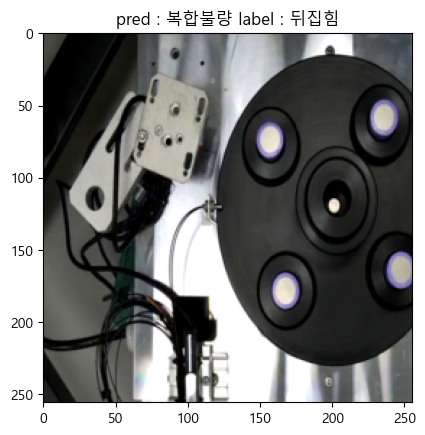

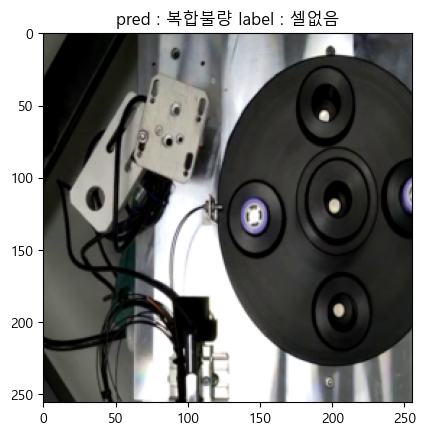

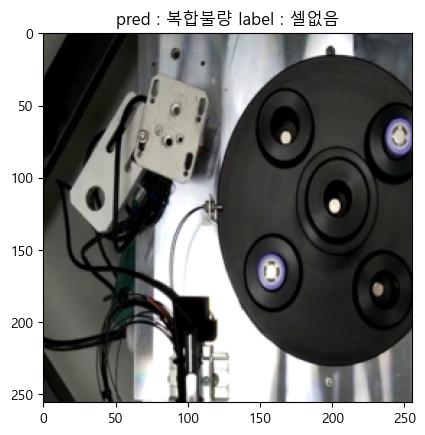

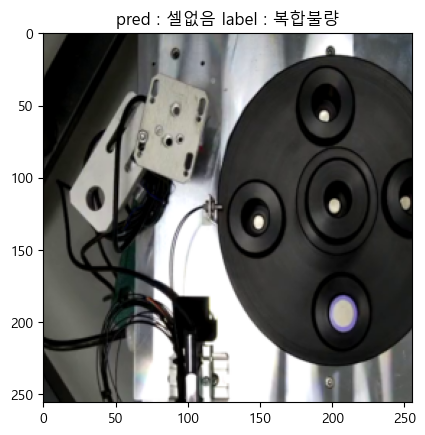

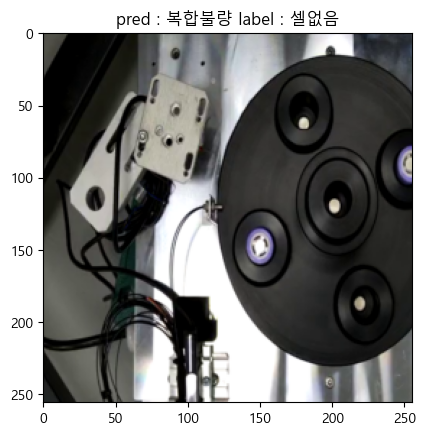

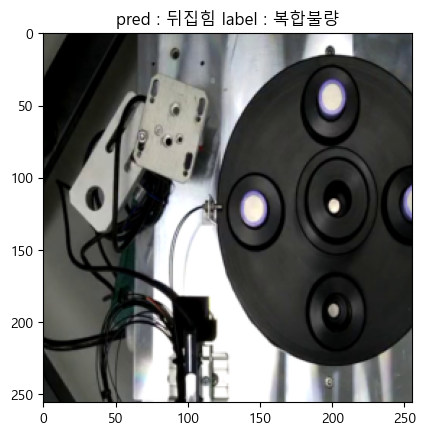

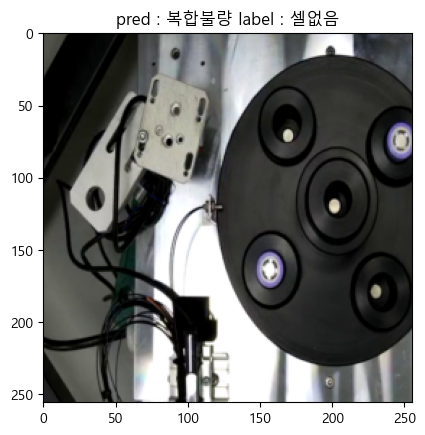

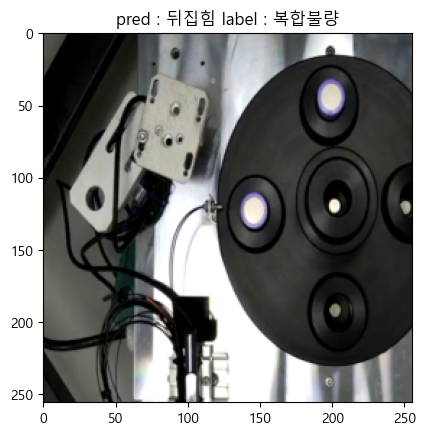

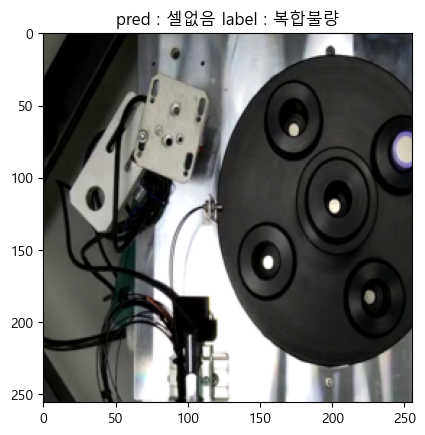

Test Error: 
 Accuracy: 95.2%, Avg loss: 0.180828 



In [14]:
misclassified_images = []
pred_labels = []
true_labels = []

with torch.no_grad():
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, correct = 0, 0
    
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        misclassified_indices = (pred.argmax(1) != y).nonzero()
        
        if misclassified_indices.shape[0] != 0:
            for j in range(len(misclassified_indices)):
                plt.imshow(transforms.ToPILImage()(X[misclassified_indices][j][0]*0.5+0.5))
                plt.title(f"pred : {dataset.classes[pred.argmax(1)[misclassified_indices[j].item()]]} label : {dataset.classes[y[misclassified_indices[j].item()]]}")
                plt.show()
                
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")